# 02_bandit_sim_polished

Portfolio-level bandit simulation over dynamic portfolio templates.

This notebook:
- Loads precomputed asset- and portfolio-level return data.
- Defines a bandit environment for portfolio templates.
- Implements Normal–Inverse-Gamma Thompson Sampling policies (mean-focused and CVaR-focused).
- Runs bandit simulations and static benchmarks.
- Summarises performance statistics.
- Runs posterior predictive checks for selected portfolio arms.


## Imports and data loading

Load preprocessed returns for individual assets and portfolio templates.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams["figure.figsize"] = (10, 6)

DATA_PROCESSED = Path("../data_processed")

# Long-format returns for all tickers (for SPY benchmark)
returns_long = pd.read_parquet(DATA_PROCESSED / "returns_long_universe.parquet")

# Precomputed dynamic portfolio returns
port_returns = pd.read_parquet(DATA_PROCESSED / "portfolio_returns_dynamic.parquet")

returns_long.head(), port_returns.head()

(        date ticker       ret
 0 2010-01-05   AAPL  0.001728
 1 2010-01-05   AMZN  0.005883
 2 2010-01-05    BAC  0.031987
 3 2010-01-05    CVX  0.007058
 4 2010-01-05    GLD -0.000911,
             date         portfolio       ret
 15784 2010-01-05  Markowitz_static  0.003374
 15785 2010-01-06  Markowitz_static -0.002281
 15786 2010-01-07  Markowitz_static  0.004022
 15787 2010-01-08  Markowitz_static  0.000735
 15788 2010-01-11  Markowitz_static -0.002843)

## Performance statistics helper

Utility to compute annualised mean, volatility, Sharpe, Sortino, and max drawdown from a return series. Assumes risk-free rate = 0

In [ ]:
def perf_stats(df: pd.DataFrame, ret_col: str = "ret", freq: int = 252):
    r = df[ret_col].dropna()

    ann_mu = r.mean() * freq
    ann_sigma = r.std() * np.sqrt(freq)
    sharpe = ann_mu / ann_sigma if ann_sigma > 0 else np.nan

    downside = r[r < 0]
    if len(downside) > 1:
        downside_sigma = downside.std() * np.sqrt(freq)
        sortino = ann_mu / downside_sigma if downside_sigma > 0 else np.nan
    else:
        sortino = np.nan

    equity = (1.0 + r).cumprod()
    peak = equity.cummax()
    dd = equity / peak - 1.0
    max_dd = dd.min()

    return {
        "ann_mu": ann_mu,
        "ann_sigma": ann_sigma,
        "sharpe": sharpe,
        "sortino": sortino,
        "max_dd": max_dd,
    }

## Portfolio bandit environment and simulators

Environment exposes the set of available portfolio templates on each date and simulates wealth evolution for bandit-driven and static strategies.

- `PortfolioBanditEnv`: bandit over portfolio templates (the main environment used in this notebook).

the environment exposes:

- `current_date()` – the current trading date index.
- `available_arms()` – the set of arms that can be played on that date.
- `step(arm)` – returns `(date, ret, done)` for the chosen arm and advances the date index.

In [ ]:
class PortfolioBanditEnv:
    def __init__(self, port_returns: pd.DataFrame):
        df = port_returns.sort_values(["date", "portfolio"])
        self.data = df
        self.dates = df["date"].unique()
        self.current_idx = 0

    def reset(self):
        self.current_idx = 0

    def current_date(self):
        return self.dates[self.current_idx]

    def available_arms(self):
        """Return portfolios that actually have returns on the current date."""
        d = self.current_date()
        return (
            self.data.loc[self.data["date"] == d, "portfolio"]
            .unique()
            .tolist()
        )

    def step(self, portfolio_name: str):
        """Advance one day using the chosen portfolio and return (date, ret, done)."""
        d = self.current_date()
        mask = (self.data["date"] == d) & (self.data["portfolio"] == portfolio_name)

        if not mask.any():
            raise ValueError(
                f"No row found for date={d} and portfolio={portfolio_name}. "
                f"Available arms on that date are: "
                f"{self.data.loc[self.data['date'] == d, 'portfolio'].unique().tolist()}"
            )

        r = float(self.data.loc[mask, "ret"].iloc[0])
        self.current_idx += 1
        done = self.current_idx >= len(self.dates)
        return d, r, done


def run_portfolio_benchmark(port_returns: pd.DataFrame,
                            portfolio_name: str,
                            label: str | None = None) -> pd.DataFrame:
    if label is None:
        label = portfolio_name

    df = (
        port_returns
        .loc[port_returns["portfolio"] == portfolio_name]
        .sort_values("date")
        .copy()
    )

    if df.empty:
        raise ValueError(f"No rows found for portfolio '{portfolio_name}' in port_returns.")

    df["wealth"] = (1.0 + df["ret"]).cumprod()
    df["strategy"] = label
    return df[["date", "portfolio", "ret", "wealth", "strategy"]]


def run_portfolio_bandit(env: PortfolioBanditEnv, policy, label: str) -> pd.DataFrame:
    env.reset()
    wealth = 1.0
    history: list[tuple] = []

    while True:
        date = env.current_date()
        arms = env.available_arms()
        if not arms:
            break

        chosen = policy.select(arms)
        d, r, done = env.step(chosen)

        wealth *= (1.0 + r)
        policy.update(chosen, r)
        history.append((d, chosen, r, wealth, label))

        if done:
            break

    result = pd.DataFrame(history, columns=["date", "portfolio", "ret", "wealth", "strategy"])
    return result

## Bandit policies: NIG Thompson Sampling

We use a Normal–Inverse-Gamma prior for unknown mean and variance of one-day returns.

Two policies are implemented:
- `NIGThompsonMeanPolicy`: standard Thompson Sampling maximising the posterior mean.
- `NIGThompsonCVaRPolicy`: risk-aware TS using CVaR of the posterior predictive, computationally done by monte carlo. 

In [ ]:
class NIGThompsonCVaRPolicy:
    def __init__(
        self,
        mu0: float = 0.0,
        kappa0: float = 1e-4,
        alpha0: float = 2.0,
        beta0: float = 1.0,
        alpha_tail: float = 0.05,
        num_samples: int = 200,
        seed: int | None = None,
    ):
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.alpha_tail = alpha_tail
        self.num_samples = num_samples
        self.arms: dict[str, dict[str, float]] = {}
        self.rng = np.random.default_rng(seed)

    def _ensure_arm(self, arm: str) -> None:
        if arm not in self.arms:
            self.arms[arm] = {"n": 0, "sum_x": 0.0, "sum_x2": 0.0}

    def _posterior_params(self, st: dict[str, float]):
        n = st["n"]
        if n == 0:
            mu_n = self.mu0
            kappa_n = self.kappa0
            alpha_n = self.alpha0
            beta_n = self.beta0
        else:
            sum_x = st["sum_x"]
            sum_x2 = st["sum_x2"]
            xbar = sum_x / n

            kappa_n = self.kappa0 + n
            mu_n = (self.kappa0 * self.mu0 + n * xbar) / kappa_n
            alpha_n = self.alpha0 + 0.5 * n

            sse = sum_x2 - n * (xbar ** 2)
            beta_n = (
                self.beta0
                + 0.5 * sse
                + (self.kappa0 * n * (xbar - self.mu0) ** 2) / (2.0 * kappa_n)
            )

        return mu_n, kappa_n, alpha_n, beta_n

    def _sample_predictive_cvar(self, mu_n, kappa_n, alpha_n, beta_n) -> float:
        gamma_samples = self.rng.gamma(
            shape=alpha_n,
            scale=1.0 / beta_n,
            size=self.num_samples,
        )
        sigma2_samples = 1.0 / gamma_samples

        mu_samples = self.rng.normal(
            loc=mu_n,
            scale=np.sqrt(sigma2_samples / kappa_n),
        )

        ret_samples = self.rng.normal(
            loc=mu_samples,
            scale=np.sqrt(sigma2_samples),
        )

        q_alpha = np.quantile(ret_samples, self.alpha_tail)
        tail = ret_samples[ret_samples <= q_alpha]
        cvar = tail.mean() if tail.size > 0 else q_alpha
        return cvar

    def select(self, arms: list[str]) -> str:
        for arm in arms:
            self._ensure_arm(arm)

        cvar_scores: dict[str, float] = {}
        for arm in arms:
            st = self.arms[arm]
            mu_n, kappa_n, alpha_n, beta_n = self._posterior_params(st)
            cvar_scores[arm] = self._sample_predictive_cvar(mu_n, kappa_n, alpha_n, beta_n)

        return max(cvar_scores, key=cvar_scores.get)

    def update(self, arm: str, reward: float) -> None:
        self._ensure_arm(arm)
        st = self.arms[arm]
        st["n"] += 1
        st["sum_x"] += reward
        st["sum_x2"] += reward ** 2


class NIGThompsonMeanPolicy:
    def __init__(self,
                 mu0: float = 0.0,
                 kappa0: float = 1e-4,
                 alpha0: float = 2.0,
                 beta0: float = 1.0,
                 seed: int | None = None):
        self.mu0 = mu0
        self.kappa0 = kappa0
        self.alpha0 = alpha0
        self.beta0 = beta0
        self.arms: dict[str, dict[str, float]] = {}
        self.rng = np.random.default_rng(seed)

    def _ensure_arm(self, arm: str) -> None:
        if arm not in self.arms:
            self.arms[arm] = {"n": 0, "sum_x": 0.0, "sum_x2": 0.0}

    def select(self, arms: list[str]) -> str:
        for arm in arms:
            self._ensure_arm(arm)

        samples: dict[str, float] = {}
        for arm in arms:
            st = self.arms[arm]
            n = st["n"]

            if n == 0:
                mu_n = self.mu0
                kappa_n = self.kappa0
                alpha_n = self.alpha0
                beta_n = self.beta0
            else:
                sum_x = st["sum_x"]
                sum_x2 = st["sum_x2"]
                xbar = sum_x / n

                kappa_n = self.kappa0 + n
                mu_n = (self.kappa0 * self.mu0 + n * xbar) / kappa_n
                alpha_n = self.alpha0 + 0.5 * n

                sse = sum_x2 - n * (xbar ** 2)
                beta_n = (
                    self.beta0
                    + 0.5 * sse
                    + (self.kappa0 * n * (xbar - self.mu0) ** 2) / (2.0 * kappa_n)
                )

            gamma_sample = self.rng.gamma(shape=alpha_n, scale=1.0 / beta_n)
            sigma2 = 1.0 / gamma_sample
            mu_sample = self.rng.normal(loc=mu_n, scale=np.sqrt(sigma2 / kappa_n))
            samples[arm] = mu_sample

        return max(samples, key=samples.get)

    def update(self, arm: str, reward: float) -> None:
        self._ensure_arm(arm)
        st = self.arms[arm]
        st["n"] += 1
        st["sum_x"] += reward
        st["sum_x2"] += reward ** 2

## Static portfolio benchmarks

Construct deterministic benchmark strategies that hold a single portfolio template throughout the sample (EW_active, EW_top5vol, MOM_top5, LOWVOL_top5, Markowitz_static).

In [6]:
ew_active_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="EW_active",
    label="EW_active_benchmark",
)

ew_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="EW_top5vol",
    label="EW_top5vol_benchmark",
)

mom_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="MOM_top5",
    label="MOM_top5_benchmark",
)

lowvol_top5_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="LOWVOL_top5",
    label="LOWVOL_top5_benchmark",
)

markowitz_results = run_portfolio_benchmark(
    port_returns=port_returns,
    portfolio_name="Markowitz_static",
    label="Markowitz_static",
)

ew_active_results.head()

,date,portfolio,ret,wealth,strategy
0,2010-04-01,EW_active,0.003725,1.003725,EW_active_benchmark
4,2010-04-05,EW_active,0.005154,1.008898,EW_active_benchmark
8,2010-04-06,EW_active,0.002564,1.011485,EW_active_benchmark
12,2010-04-07,EW_active,-0.001167,1.010305,EW_active_benchmark
16,2010-04-08,EW_active,0.005380,1.015740,EW_active_benchmark


## Portfolio-level Thompson Sampling simulations

We now run the bandit using portfolio templates as arms:

- `TS_mean_port`: Thompson sampling on the predictive mean return.
- `TS_cvar_port`: risk-aware TS on posterior predictive CVaR (5% tail).

In [ ]:
# Mean-focused Thompson Sampling over portfolio templates
port_env = PortfolioBanditEnv(port_returns)
ts_mean_port_policy = NIGThompsonMeanPolicy(seed=321)

port_ts_mean_results = run_portfolio_bandit(
    env=port_env,
    policy=ts_mean_port_policy,
    label="TS_mean_port",
)

stats_mean_port = perf_stats(port_ts_mean_results, ret_col="ret")
print("TS_mean_port →",
      "ann μ:", stats_mean_port["ann_mu"],
      "ann σ:", stats_mean_port["ann_sigma"],
      "Sharpe:", stats_mean_port["sharpe"],
      "max DD:", stats_mean_port["max_dd"],
      "Sortino:", stats_mean_port["sortino"],
      )

# Risk-aware (CVaR-based) Thompson Sampling over portfolio templates
port_env_cvar = PortfolioBanditEnv(port_returns)
ts_cvar_port_policy = NIGThompsonCVaRPolicy(
    alpha_tail=0.05,
    num_samples=200,
    seed=321,
)

port_ts_cvar_results = run_portfolio_bandit(
    env=port_env_cvar,
    policy=ts_cvar_port_policy,
    label="TS_cvar_port",
)

stats_cvar_port = perf_stats(port_ts_cvar_results, ret_col="ret")
print("TS_cvar_port →",
      "ann μ:", stats_cvar_port["ann_mu"],
      "ann σ:", stats_cvar_port["ann_sigma"],
      "Sharpe:", stats_cvar_port["sharpe"],
      "Sortino:", stats_cvar_port["sortino"],
      "max DD:", stats_cvar_port["max_dd"],
      )

TS_mean_port → ann μ: 0.1767492661544171 ann σ: 0.19710656068082788 Sharpe: 0.8967193458396594 max DD: -0.38895067825462204 Sortino: 1.0788469173966917
TS_cvar_port → ann μ: 0.08739314888982948 ann σ: 0.07913800579323657 Sharpe: 1.104313256492223 Sortino: 1.3813922978642807 max DD: -0.20292931128938219


## SPY buy-and-hold benchmark and performance comparison

Construct a SPY buy-and-hold benchmark and compare all portfolio strategies and bandit policies in terms of wealth paths and performance statistics.

We also plot the equity curves (growth of $1) for SPY, static portfolio templates, and the Thompson bandit strategies on portfolio templates.

In [8]:
# SPY buy & hold benchmark
spy_ret = (
    returns_long.query("ticker == 'SPY'")
    .sort_values("date")[["date", "ret"]]
    .copy()
)

spy_ret["wealth"] = (1.0 + spy_ret["ret"]).cumprod()
spy_ret["strategy"] = "SPY_buy_and_hold"
spy_results = spy_ret[["date", "ret", "wealth", "strategy"]]

# Collect strategies in a single table
port_ts_mean_results = port_ts_mean_results.sort_values("date")
port_ts_cvar_results = port_ts_cvar_results.sort_values("date")

strategies = {
    "SPY_buy_and_hold": spy_results,
    "TS_mean_port": port_ts_mean_results,
    "TS_cvar_port": port_ts_cvar_results,
    "EW_active": ew_active_results,
    "EW_top5vol": ew_top5_results,
    "MOM_top5": mom_top5_results,
    "LOWVOL_top5": lowvol_top5_results,
    "Markowitz_static": markowitz_results,
}

rows = []
for name, df in strategies.items():
    stats = perf_stats(df, ret_col="ret")
    rows.append({
        "strategy": name,
        "ann_mu": stats["ann_mu"],
        "ann_sigma": stats["ann_sigma"],
        "sharpe": stats["sharpe"],
        "sortino": stats["sortino"],
        "max_dd": stats["max_dd"],
    })

perf_table = pd.DataFrame(rows).set_index("strategy")
perf_table

,ann_mu,ann_sigma,sharpe,sortino,max_dd
strategy,,,,,
SPY_buy_and_hold,0.131127,0.172706,0.759249,0.912573,-0.357459
TS_mean_port,0.176749,0.197107,0.896719,1.078847,-0.388951
TS_cvar_port,0.087393,0.079138,1.104313,1.381392,-0.202929
EW_active,0.149012,0.175566,0.848753,1.022129,-0.353408
EW_top5vol,0.190759,0.270494,0.705225,0.916400,-0.503470
MOM_top5,0.207569,0.204066,1.017165,1.305584,-0.329762
LOWVOL_top5,0.087587,0.136741,0.640528,0.792427,-0.214647
Markowitz_static,0.087393,0.079138,1.104313,1.381392,-0.202929


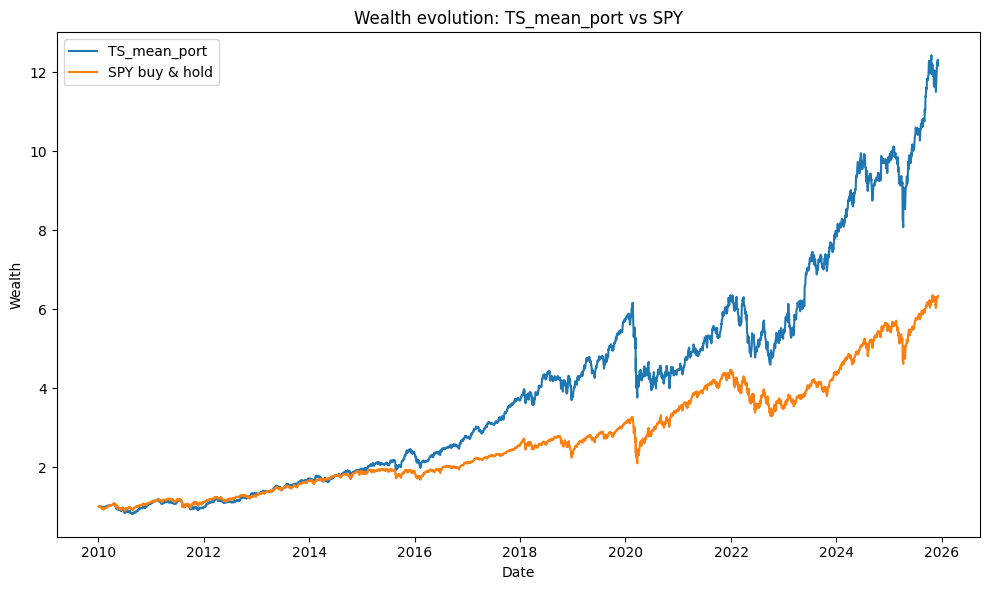

In [15]:
plt.figure(figsize=(10, 6))
plt.plot(ts_mean_port_equity.index, ts_mean_port_equity, label="TS_mean_port")
plt.plot(spy_equity.index, spy_equity, label="SPY buy & hold")
plt.title("Wealth evolution: TS_mean_port vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.tight_layout()
plt.show()



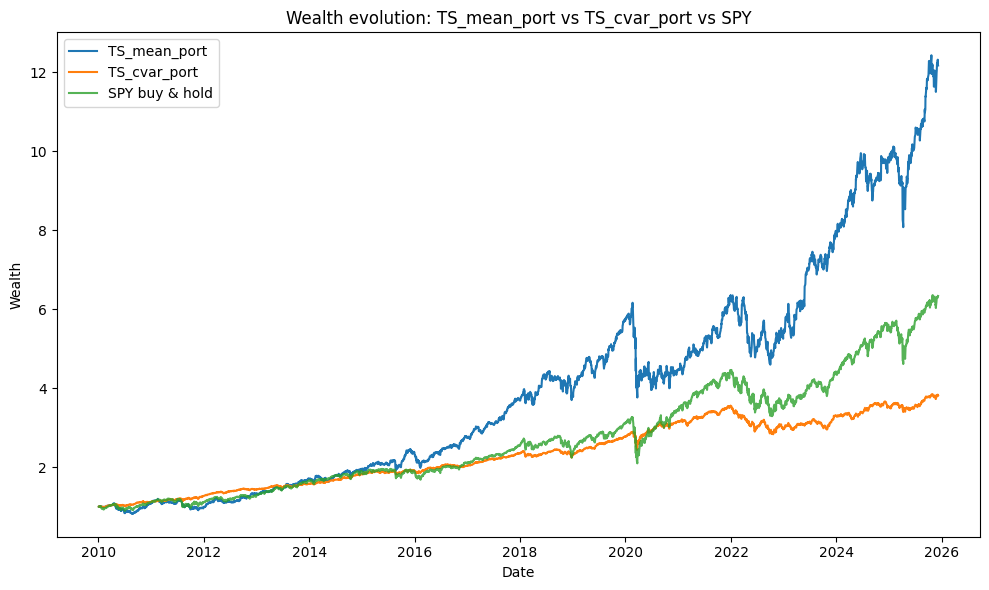

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(ts_mean_port_equity.index, ts_mean_port_equity, label="TS_mean_port")
plt.plot(ts_cvar_port_equity.index, ts_cvar_port_equity, label="TS_cvar_port")
plt.plot(spy_equity.index, spy_equity, label="SPY buy & hold", alpha=0.8)
plt.title("Wealth evolution: TS_mean_port vs TS_cvar_port vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.tight_layout()
plt.show()

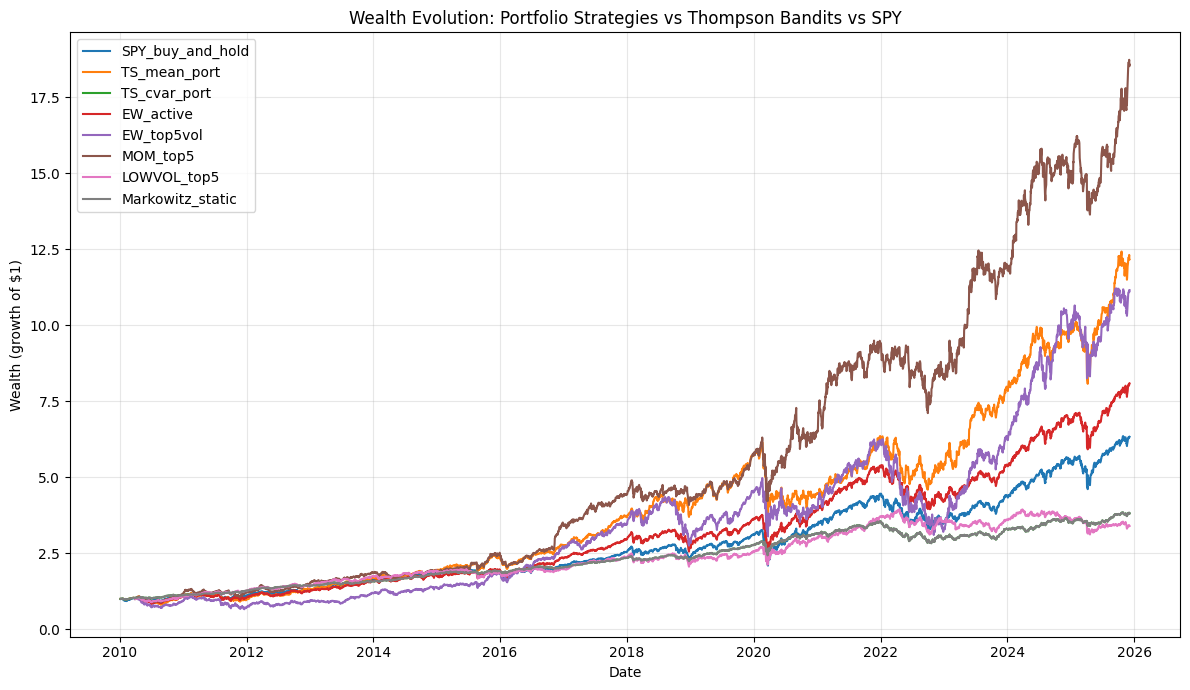

In [9]:
# Combined wealth comparison plot: portfolio strategies + TS bandits + SPY
plt.figure(figsize=(12, 7))

for label, df in strategies.items():
    df_ = df.sort_values("date").copy()
    plt.plot(df_["date"], df_["wealth"], label=label)

plt.title("Wealth Evolution: Portfolio Strategies vs Thompson Bandits vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth (growth of $1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Normal–Inverse-Gamma posterior predictive utilities

Helper functions to compute NIG posterior parameters from sufficient statistics and draw posterior predictive samples for one-step-ahead returns.     We draw samples from the NIG posterior predictive of a single-step return.

    sigma^2 ~ Inv-Gamma(alpha_n, beta_n)
    mu      ~ Normal(mu_n, sigma^2 / kappa_n)
    r       ~ Normal(mu, sigma^2)



In [ ]:
def nig_posterior_params_from_stats(mu0: float, kappa0: float,
                                    alpha0: float, beta0: float,
                                    st: dict[str, float]):
    # Compute NIG posterior parameters (mu_n, kappa_n, alpha_n, beta_n)
    # from prior hyperparameters and sufficient statistics st = {n, sum_x, sum_x2}.
    n = st["n"]

    if n == 0:
        mu_n = mu0
        kappa_n = kappa0
        alpha_n = alpha0
        beta_n = beta0
    else:
        sum_x = st["sum_x"]
        sum_x2 = st["sum_x2"]
        xbar = sum_x / n

        kappa_n = kappa0 + n
        mu_n = (kappa0 * mu0 + n * xbar) / kappa_n
        alpha_n = alpha0 + 0.5 * n

        sse = sum_x2 - n * (xbar ** 2)
        beta_n = (
            beta0
            + 0.5 * sse
            + (kappa0 * n * (xbar - mu0) ** 2) / (2.0 * kappa_n)
        )

    return mu_n, kappa_n, alpha_n, beta_n


def posterior_predictive_samples_nig(mu_n: float, kappa_n: float,
                                     alpha_n: float, beta_n: float,
                                     num_samples: int = 5000,
                                     rng: np.random.Generator | None = None):
    if rng is None:
        rng = np.random.default_rng()

    gamma_samples = rng.gamma(shape=alpha_n, scale=1.0 / beta_n, size=num_samples)
    sigma2_samples = 1.0 / gamma_samples

    mu_samples = rng.normal(loc=mu_n, scale=np.sqrt(sigma2_samples / kappa_n))
    r_samples = rng.normal(loc=mu_samples, scale=np.sqrt(sigma2_samples))
    return r_samples

## Posterior predictive checks for selected portfolio arms

Use the sufficient statistics accumulated by the bandit policies to generate posterior predictive distributions for selected portfolios, and compare to realised returns.
We also run a posterior predictive check for the k-th PPC target.
Uses the NIG posterior from the given policy and portfolio arm, draws posterior predictive samples, and compares with realised returns over the last lookback days.


1: TS_mean_port: EW_active | portfolio=EW_active
2: TS_mean_port: MOM_top5 | portfolio=MOM_top5

=== PPC for target 1: TS_mean_port: EW_active (portfolio = EW_active) ===
Posterior predictive:
 mean: 0.0010698087906822295
 5% quantile: -0.08594039360146455
 95% quantile: 0.0879162269378621

Realised returns (portfolio 'EW_active', last 252 days):
 empirical mean: 0.0006121406751674594
 empirical std: 0.010776371324010312
 fraction below predictive 5% quantile: 0.0


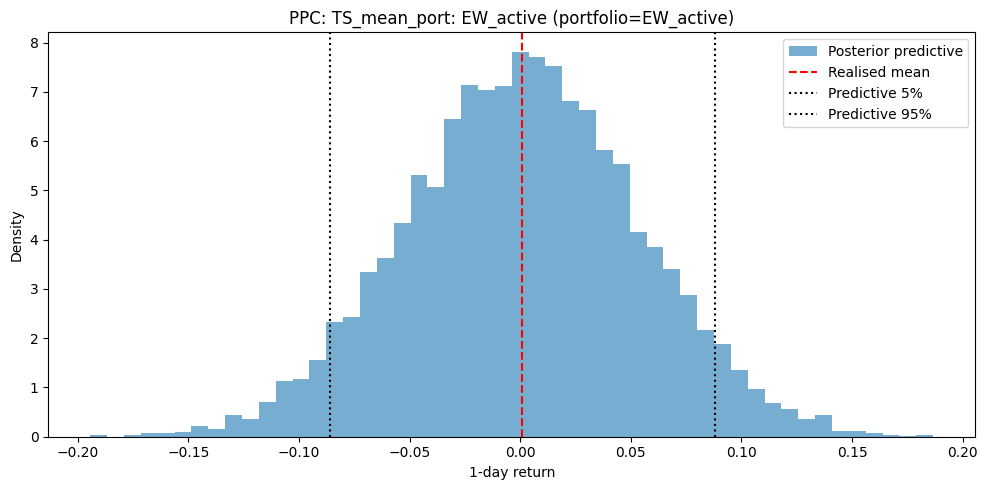


=== PPC for target 2: TS_mean_port: MOM_top5 (portfolio = MOM_top5) ===
Posterior predictive:
 mean: 0.0016415081375915613
 5% quantile: -0.08241699756975657
 95% quantile: 0.08562494191627702

Realised returns (portfolio 'MOM_top5', last 252 days):
 empirical mean: 0.0008273559497791908
 empirical std: 0.011403435570539201
 fraction below predictive 5% quantile: 0.0


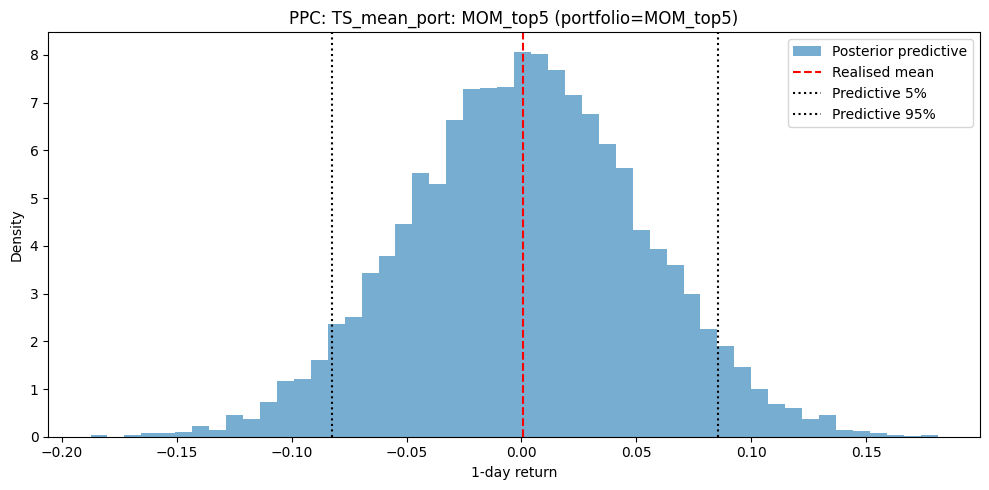

In [ ]:
# Define PPC targets: (label, policy_obj, portfolio_name)
ppc_targets = {
    1: ("TS_mean_port: EW_active", ts_mean_port_policy, "EW_active"),
    2: ("TS_mean_port: MOM_top5", ts_mean_port_policy, "MOM_top5"),
}

for k, (label, policy, port_name) in ppc_targets.items():
    print(f"{k}: {label} | portfolio={port_name}")


def run_ppc_for_index(
    k: int,
    num_samples: int = 10000,
    lookback: int = 252,
    rng_seed: int = 321,
):
    if k not in ppc_targets:
        raise ValueError(f"PPC index {k} not in ppc_targets.")

    label, policy, port_name = ppc_targets[k]
    print(f"\n=== PPC for target {k}: {label} (portfolio = {port_name}) ===")

    if port_name not in policy.arms:
        raise ValueError(
            f"Portfolio '{port_name}' not found in policy.arms. "
            "Did you run the bandit simulation before calling PPC?"
        )

    st = policy.arms[port_name]

    mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
        mu0=policy.mu0,
        kappa0=policy.kappa0,
        alpha0=policy.alpha0,
        beta0=policy.beta0,
        st=st,
    )

    rng = np.random.default_rng(rng_seed)
    ppc_samples = posterior_predictive_samples_nig(
        mu_n, kappa_n, alpha_n, beta_n,
        num_samples=num_samples,
        rng=rng,
    )

    ppc_mean = np.mean(ppc_samples)
    ppc_q05 = np.quantile(ppc_samples, 0.05)
    ppc_q95 = np.quantile(ppc_samples, 0.95)

    print("Posterior predictive:")
    print(" mean:", ppc_mean)
    print(" 5% quantile:", ppc_q05)
    print(" 95% quantile:", ppc_q95)

    realized = (
        port_returns.query("portfolio == @port_name")
        .sort_values("date")["ret"]
    )
    if len(realized) > lookback:
        realized = realized.tail(lookback)

    frac_below_q05 = (realized < ppc_q05).mean()

    print(f"\nRealised returns (portfolio '{port_name}', last {len(realized)} days):")
    print(" empirical mean:", realized.mean())
    print(" empirical std:", realized.std())
    print(" fraction below predictive 5% quantile:", frac_below_q05)

    plt.figure(figsize=(10, 5))
    plt.hist(ppc_samples, bins=50, alpha=0.6, density=True,
             label="Posterior predictive")
    plt.axvline(realized.mean(), color="red", linestyle="--",
                label="Realised mean")
    plt.axvline(ppc_q05, color="black", linestyle=":",
                label="Predictive 5%")
    plt.axvline(ppc_q95, color="black", linestyle=":",
                label="Predictive 95%")

    plt.title(f"PPC: {label} (portfolio={port_name})")
    plt.xlabel("1-day return")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


# Example PPC runs
run_ppc_for_index(1)
run_ppc_for_index(2)

## Full-history NIG posterior for a single portfolio template

As a secondary check, fit a Normal–Inverse-Gamma model using full historical returns
for a single portfolio (e.g. MOM_top5) and compare its posterior predictive to realised returns.

Posterior predictive for portfolio MOM_top5:
 mean: 0.0011683759788483979
 5% quantile: -0.04132984863053904
 95% quantile: 0.043622129540670025

Realised MOM_top5 returns (last 252 days):
 empirical mean: 0.0008273559497791908
 empirical std: 0.011403435570539201
 fraction below predictive 5% quantile: 0.003968253968253968


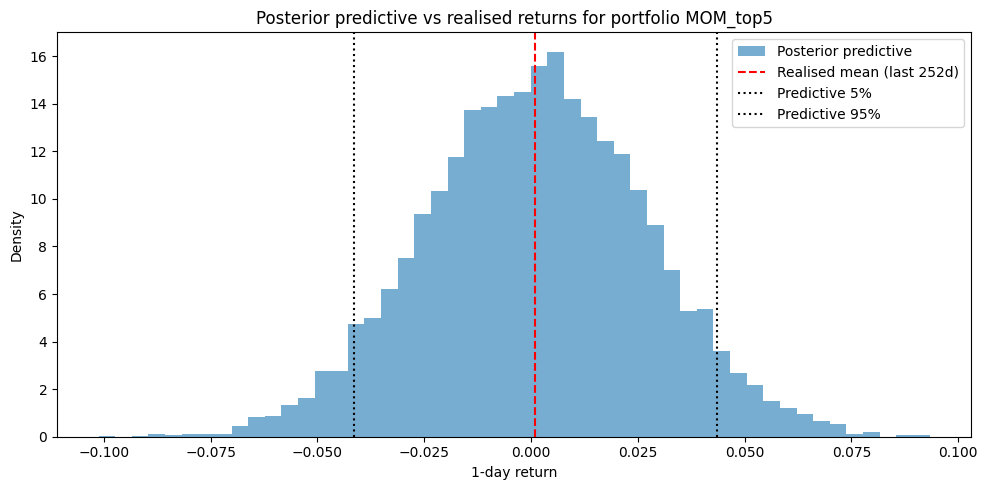

In [12]:
port_arm = "MOM_top5"

port_series = (
    port_returns
    .query("portfolio == @port_arm")
    .sort_values("date")["ret"]
)

st_port = {
    "n": len(port_series),
    "sum_x": float(port_series.sum()),
    "sum_x2": float((port_series ** 2).sum()),
}

mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
    mu0=0.0,
    kappa0=1e-4,
    alpha0=2.0,
    beta0=1.0,
    st=st_port,
)

rng = np.random.default_rng(999)
ppc_samples_port = posterior_predictive_samples_nig(
    mu_n, kappa_n, alpha_n, beta_n,
    num_samples=10000,
    rng=rng,
)

ppc_mean = np.mean(ppc_samples_port)
ppc_q05 = np.quantile(ppc_samples_port, 0.05)
ppc_q95 = np.quantile(ppc_samples_port, 0.95)

print(f"Posterior predictive for portfolio {port_arm}:")
print(" mean:", ppc_mean)
print(" 5% quantile:", ppc_q05)
print(" 95% quantile:", ppc_q95)

realized_port = port_series.tail(252)
frac_below_q05 = (realized_port < ppc_q05).mean()

print(f"\nRealised {port_arm} returns (last {len(realized_port)} days):")
print(" empirical mean:", realized_port.mean())
print(" empirical std:", realized_port.std())
print(" fraction below predictive 5% quantile:", frac_below_q05)

plt.figure(figsize=(10, 5))
plt.hist(ppc_samples_port, bins=50, alpha=0.6, density=True,
         label="Posterior predictive")
plt.axvline(realized_port.mean(), color="red", linestyle="--",
            label="Realised mean (last 252d)")
plt.axvline(ppc_q05, color="black", linestyle=":", label="Predictive 5%")
plt.axvline(ppc_q95, color="black", linestyle=":", label="Predictive 95%")
plt.title(f"Posterior predictive vs realised returns for portfolio {port_arm}")
plt.xlabel("1-day return")
plt.ylabel("Density")
plt.legend()
plt.tight_layout()
plt.show()

Results Export

In [ ]:
from pathlib import Path

RESULTS_DIR = Path("../results_bandit")
RESULTS_DIR.mkdir(parents=True, exist_ok=True)
print("Saving results to:", RESULTS_DIR)

perf_table.to_csv(RESULTS_DIR / "perf_table.csv")
print("Saved perf_table.csv")

wealth_frames = []
for name, df in strategies.items():
    tmp = df[["date", "wealth"]].copy()
    tmp["strategy"] = name
    wealth_frames.append(tmp)

wealth_long = pd.concat(wealth_frames, ignore_index=True)
wealth_long.to_parquet(RESULTS_DIR / "wealth_curves.parquet")
wealth_long.to_csv(RESULTS_DIR / "wealth_curves.csv", index=False)
print("Saved wealth_curves.{parquet,csv}")

port_choice_counts_mean = (
    port_ts_mean_results["portfolio"]
    .value_counts()
    .rename_axis("portfolio")
    .reset_index(name="count")
)
port_choice_counts_mean.to_csv(
    RESULTS_DIR / "port_ts_mean_choice_counts.csv", index=False
)
print("Saved port_ts_mean_choice_counts.csv")

port_choice_counts_cvar = (
    port_ts_cvar_results["portfolio"]
    .value_counts()
    .rename_axis("portfolio")
    .reset_index(name="count")
)
port_choice_counts_cvar.to_csv(
    RESULTS_DIR / "port_ts_cvar_choice_counts.csv", index=False
)
print("Saved port_ts_cvar_choice_counts.csv")

r_port = port_ts_mean_results.set_index("date")["ret"]
window = 252
roll_mu_port = r_port.rolling(window).mean() * 252
roll_sigma_port = r_port.rolling(window).std() * np.sqrt(252)
roll_sharpe_port = (roll_mu_port / roll_sigma_port).dropna()

roll_sharpe_port.to_csv(
    RESULTS_DIR / "port_ts_mean_rolling_sharpe_252d.csv",
    header=["rolling_sharpe"]
)
print("Saved port_ts_mean_rolling_sharpe_252d.csv")

spy_equity = spy_results.set_index("date")["wealth"]
ts_mean_port_equity = port_ts_mean_results.set_index("date")["wealth"]
ts_cvar_port_equity = port_ts_cvar_results.set_index("date")["wealth"]

plt.figure(figsize=(10, 6))
plt.plot(ts_mean_port_equity.index, ts_mean_port_equity, label="TS_mean_port")
plt.plot(spy_equity.index, spy_equity, label="SPY buy & hold")
plt.title("Wealth evolution: TS_mean_port vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "equity_ts_mean_port_vs_spy.png", dpi=200)
plt.close()

plt.figure(figsize=(10, 6))
plt.plot(ts_mean_port_equity.index, ts_mean_port_equity, label="TS_mean_port")
plt.plot(ts_cvar_port_equity.index, ts_cvar_port_equity, label="TS_cvar_port")
plt.plot(spy_equity.index, spy_equity, label="SPY buy & hold", alpha=0.8)
plt.title("Wealth evolution: TS_mean_port vs TS_cvar_port vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth")
plt.legend()
plt.tight_layout()
plt.savefig(RESULTS_DIR / "equity_ts_mean_vs_cvar_port_vs_spy.png", dpi=200)
plt.close()

plt.figure(figsize=(12, 7))
strategy_series = [
    ("SPY_buy_and_hold", spy_results),
    ("EW_active",        strategies["EW_active"]),
    ("EW_top5vol",       strategies["EW_top5vol"]),
    ("MOM_top5",         strategies["MOM_top5"]),
    ("LOWVOL_top5",      strategies["LOWVOL_top5"]),
    ("TS_mean_port",     port_ts_mean_results),
    ("TS_cvar_port",     port_ts_cvar_results),
]
for lbl, df in strategy_series:
    df_ = df.sort_values("date").copy()
    plt.plot(df_["date"], df_["wealth"], label=lbl)

plt.title("Wealth Evolution: Portfolio Strategies vs Thompson Bandits vs SPY")
plt.xlabel("Date")
plt.ylabel("Wealth (growth of $1)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(RESULTS_DIR / "equity_all_portfolio_strategies.png", dpi=200)
plt.close()

print("Saved equity curve figures")

ppc_targets = {
    1: ("TS_mean_port: EW_active", ts_mean_port_policy, "EW_active"),
    2: ("TS_mean_port: MOM_top5", ts_mean_port_policy, "MOM_top5"),
    3: ("TS_cvar_port: EW_active", ts_cvar_port_policy, "EW_active"),
    4: ("TS_cvar_port: MOM_top5", ts_cvar_port_policy, "MOM_top5"),
}

for k, (label, policy, arm_name) in ppc_targets.items():
    print(f"{k}: {label} | arm={arm_name}")

def ppc_summary_for_index(
    k: int,
    num_samples: int = 10000,
    lookback: int = 252,
    rng_seed: int = 321,
):
    """
    Numerical-only PPC summary for index k in ppc_targets.
    Only portfolio-level arms are considered.
    """
    if k not in ppc_targets:
        raise ValueError(f"PPC index {k} not in ppc_targets.")

    label, policy, arm_name = ppc_targets[k]

    if arm_name not in policy.arms:
        raise ValueError(
            f"Arm '{arm_name}' not found in policy.arms. "
            "Did you run the bandit simulation before calling PPC?"
        )

    st = policy.arms[arm_name]

    mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
        mu0=policy.mu0,
        kappa0=policy.kappa0,
        alpha0=policy.alpha0,
        beta0=policy.beta0,
        st=st,
    )

    rng = np.random.default_rng(rng_seed)
    ppc_samples = posterior_predictive_samples_nig(
        mu_n, kappa_n, alpha_n, beta_n,
        num_samples=num_samples,
        rng=rng,
    )

    ppc_mean = float(np.mean(ppc_samples))
    ppc_q05 = float(np.quantile(ppc_samples, 0.05))
    ppc_q95 = float(np.quantile(ppc_samples, 0.95))

    realized = (
        port_returns.query("portfolio == @arm_name")
        .sort_values("date")["ret"]
    )
    if len(realized) > lookback:
        realized = realized.tail(lookback)

    frac_below_q05 = float((realized < ppc_q05).mean())
    realized_mean = float(realized.mean())
    realized_std = float(realized.std())

    return {
        "ppc_index": k,
        "label": label,
        "arm_name": arm_name,
        "ppc_mean": ppc_mean,
        "ppc_q05": ppc_q05,
        "ppc_q95": ppc_q95,
        "realized_mean": realized_mean,
        "realized_std": realized_std,
        "realized_n": int(len(realized)),
        "frac_below_ppc_q05": frac_below_q05,
    }

ppc_summaries = [ppc_summary_for_index(k) for k in sorted(ppc_targets.keys())]
ppc_df = pd.DataFrame(ppc_summaries)
ppc_df.to_csv(RESULTS_DIR / "ppc_summaries.csv", index=False)
print("Saved ppc_summaries.csv")

for k in sorted(ppc_targets.keys()):
    label, policy, arm_name = ppc_targets[k]
    print(f"Plotting PPC figure for index {k}: {label}")

    st = policy.arms[arm_name]
    mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
        mu0=policy.mu0,
        kappa0=policy.kappa0,
        alpha0=policy.alpha0,
        beta0=policy.beta0,
        st=st,
    )

    rng = np.random.default_rng(321)
    ppc_samples = posterior_predictive_samples_nig(
        mu_n, kappa_n, alpha_n, beta_n,
        num_samples=10000,
        rng=rng,
    )

    realized = (
        port_returns.query("portfolio == @arm_name")
        .sort_values("date")["ret"]
    )
    realized = realized.tail(252)

    ppc_q05 = np.quantile(ppc_samples, 0.05)
    ppc_q95 = np.quantile(ppc_samples, 0.95)

    plt.figure(figsize=(10, 5))
    plt.hist(ppc_samples, bins=50, alpha=0.6, density=True,
             label="Posterior predictive")
    plt.axvline(realized.mean(), color="red", linestyle="--",
                label="Realised mean")
    plt.axvline(ppc_q05, color="black", linestyle=":",
                label="Predictive 5%")
    plt.axvline(ppc_q95, color="black", linestyle=":",
                label="Predictive 95%")

    plt.title(f"PPC: {label} (portfolio={arm_name})")
    plt.xlabel("1-day return")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS_DIR / f"ppc_{k}_{arm_name}.png", dpi=200)
    plt.close()

print("Saved PPC figures")

port_arm = "MOM_top5"

port_series = (
    port_returns
    .query("portfolio == @port_arm")
    .sort_values("date")["ret"]
)

st_port = {
    "n": len(port_series),
    "sum_x": float(port_series.sum()),
    "sum_x2": float((port_series**2).sum()),
}

mu_n, kappa_n, alpha_n, beta_n = nig_posterior_params_from_stats(
    mu0=0.0,
    kappa0=1e-4,
    alpha0=2.0,
    beta0=1.0,
    st=st_port,
)

rng = np.random.default_rng(999)
ppc_samples_port = posterior_predictive_samples_nig(
    mu_n, kappa_n, alpha_n, beta_n,
    num_samples=10000,
    rng=rng,
)

ppc_mean = float(np.mean(ppc_samples_port))
ppc_q05 = float(np.quantile(ppc_samples_port, 0.05))
ppc_q95 = float(np.quantile(ppc_samples_port, 0.95))

realized_port = port_series.tail(252)
frac_below_q05 = float((realized_port < ppc_q05).mean())

ppc_mom_row = pd.DataFrame([{
    "portfolio": port_arm,
    "ppc_mean": ppc_mean,
    "ppc_q05": ppc_q05,
    "ppc_q95": ppc_q95,
    "realized_mean": float(realized_port.mean()),
    "realized_std": float(realized_port.std()),
    "realized_n": int(len(realized_port)),
    "frac_below_ppc_q05": frac_below_q05,
}])

ppc_mom_row.to_csv(RESULTS_DIR / "ppc_MOM_top5_full_history.csv", index=False)
print("Saved ppc_MOM_top5_full_history.csv")


Saving results to: ..\results_bandit
Saved perf_table.csv
Saved wealth_curves.{parquet,csv}
Saved port_ts_mean_choice_counts.csv
Saved port_ts_cvar_choice_counts.csv
Saved port_ts_mean_rolling_sharpe_252d.csv
Saved equity curve figures
1: TS_mean_port: EW_active | arm=EW_active
2: TS_mean_port: MOM_top5 | arm=MOM_top5
3: TS_cvar_port: EW_active | arm=EW_active
4: TS_cvar_port: MOM_top5 | arm=MOM_top5
Saved ppc_summaries.csv
Plotting PPC figure for index 1: TS_mean_port: EW_active
Plotting PPC figure for index 2: TS_mean_port: MOM_top5
Plotting PPC figure for index 3: TS_cvar_port: EW_active
Plotting PPC figure for index 4: TS_cvar_port: MOM_top5
Saved PPC figures
Saved ppc_MOM_top5_full_history.csv
